In [1]:
import cv2
import numpy as np
import os, glob, random
import datetime
import matplotlib.pyplot as plt

In [2]:
cv2.__version__

'3.4.14'

In [3]:
base_path = "D:/vision_final_data/x_ray_images/Astrophysics/"
categories = ['Electronic cigarettes', 'Gun', 'Liquid', 'SmartPhone']
dict_file = './x_ray_dict.npy'
svm_model_file = './x_ray_svm.xml'
dictionary_size = 1000

In [4]:
detector = cv2.xfeatures2d.SIFT_create()
matcher = cv2.BFMatcher(cv2.NORM_L2)
bowTrainer = cv2.BOWKMeansTrainer(dictionary_size)
bowExtractor = cv2.BOWImgDescriptorExtractor(detector, matcher)

In [5]:
# 학습 200건 / 검증 50건 으로 맞춰서 진행 (Single_Default 전자담배 250건으로 제일 적음)
# Electronic cigarettes : 250 / Gun : 800 / Liquid : 625 / SmartPhone : 375
electronic_cigarettes_train_set = []
gun_train_set = []
liquid_train_set = []
smartphone_train_set = []

for label, category in enumerate(categories):
    dir_path = base_path + category + '/Single_Default/'
    for i in range(250):
        img_path = random.choice(glob.glob(dir_path+'/*.*'))
        if category == 'Electronic cigarettes':
            electronic_cigarettes_train_set.append(img_path)
        elif category == 'Gun':
            gun_train_set.append(img_path)
        elif category == 'Liquid':
            liquid_train_set.append(img_path)
        elif category == 'SmartPhone':
            smartphone_train_set.append(img_path)

# 학습 / 검증 데이터 분리
ec_train = electronic_cigarettes_train_set[:200]
ec_valid = electronic_cigarettes_train_set[200:]
gun_train = gun_train_set[:200]
gun_valid = gun_train_set[200:]
liquid_train = liquid_train_set[:200]
liquid_valid = liquid_train_set[200:]
sp_train = smartphone_train_set[:200]
sp_valid = smartphone_train_set[200:]

In [6]:
# 학습 데이터 불러오기
train_paths = []
train_labels = []

train_set = [ec_train, gun_train, liquid_train, sp_train]
valid_set = [ec_valid, gun_valid, liquid_valid, sp_valid]

for idx, categorical_train_set in enumerate(train_set):
    img_len = len(categorical_train_set)
    for i, img_path in enumerate(categorical_train_set):
        train_paths.append(img_path)
        train_labels.append(idx)
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kpt, desc = detector.detectAndCompute(gray, None)
        bowTrainer.add(desc)
        print('{0} {1}/{2}({3})'.format(categories[idx], i+1, img_len, (i+1)/img_len*100))

Electronic cigarettes 1/200(0.5)
Electronic cigarettes 2/200(1.0)
Electronic cigarettes 3/200(1.5)
Electronic cigarettes 4/200(2.0)
Electronic cigarettes 5/200(2.5)
Electronic cigarettes 6/200(3.0)
Electronic cigarettes 7/200(3.5000000000000004)
Electronic cigarettes 8/200(4.0)
Electronic cigarettes 9/200(4.5)
Electronic cigarettes 10/200(5.0)
Electronic cigarettes 11/200(5.5)
Electronic cigarettes 12/200(6.0)
Electronic cigarettes 13/200(6.5)
Electronic cigarettes 14/200(7.000000000000001)
Electronic cigarettes 15/200(7.5)
Electronic cigarettes 16/200(8.0)
Electronic cigarettes 17/200(8.5)
Electronic cigarettes 18/200(9.0)
Electronic cigarettes 19/200(9.5)
Electronic cigarettes 20/200(10.0)
Electronic cigarettes 21/200(10.5)
Electronic cigarettes 22/200(11.0)
Electronic cigarettes 23/200(11.5)
Electronic cigarettes 24/200(12.0)
Electronic cigarettes 25/200(12.5)
Electronic cigarettes 26/200(13.0)
Electronic cigarettes 27/200(13.5)
Electronic cigarettes 28/200(14.000000000000002)
Elect

In [7]:
print("시작 시간: ", datetime.datetime.now())
dictionary = bowTrainer.cluster()
np.save(dict_file, dictionary)
print("끝 시간: ", datetime.datetime.now())

시작 시간:  2021-12-15 00:33:59.953389
끝 시간:  2021-12-15 01:00:24.608695


In [8]:
bowExtractor.setVocabulary(dictionary)
train_desc = []
for i, path in enumerate(train_paths):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist = bowExtractor.compute(gray, detector.detect(gray))
    train_desc.extend(hist)

In [9]:
svm = cv2.ml.SVM_create()
print("시작 시간: ", datetime.datetime.now())
svm.trainAuto(np.array(train_desc), cv2.ml.ROW_SAMPLE, np.array(train_labels))
svm.save(svm_model_file)
print("끝 시간: ", datetime.datetime.now())

시작 시간:  2021-12-15 01:10:45.740735
끝 시간:  2021-12-15 01:11:29.850074


In [13]:
# validation
wrong_predict = []

print("시작 시간: ", datetime.datetime.now())
for label, categorical_valid_set in enumerate(valid_set):
    labels = []
    results = []
    for img_path in categorical_valid_set:
        labels.append(label)
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hist = bowExtractor.compute(gray, detector.detect(gray))
        ret, result = svm.predict(hist)
        resp = result[0][0]
        results.append(resp)
    labels = np.array(labels)
    results = np.array(results)
    err = (labels != results)
    idx = 0
    for i in err:
        if i:
            wrong_predict.append([idx, categories[label], categories[int(results[idx])]])
        idx += 1
    err_mean = err.mean()
    print("{0} : {1}".format(categories[label], (1-err_mean)*100))
print("끝 시간: ", datetime.datetime.now())

시작 시간:  2021-12-15 01:24:26.257324
Electronic cigarettes : 100.0
Gun : 100.0
Liquid : 100.0
SmartPhone : 94.0
끝 시간:  2021-12-15 01:27:03.955545


In [14]:
# err idx 및 예측 결과 확인
print("index / right label / predict label")
for i in range(len(wrong_predict)):
    print(wrong_predict[i])

index / right label / predict label
[5, 'SmartPhone', 'Liquid']
[6, 'SmartPhone', 'Liquid']
[32, 'SmartPhone', 'Liquid']


In [18]:
print(sp_valid[5])
print(sp_valid[6])
print(sp_valid[32])

D:/vision_final_data/x_ray_images/Astrophysics/SmartPhone/Single_Default\S_8517.70-1029_08_061.png
D:/vision_final_data/x_ray_images/Astrophysics/SmartPhone/Single_Default\S_8517.70-1029_06_066.png
D:/vision_final_data/x_ray_images/Astrophysics/SmartPhone/Single_Default\S_8517.70-1029_11_069.png


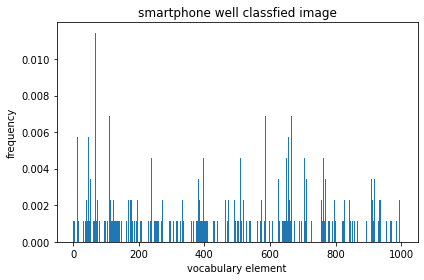

In [29]:
# hist 비교
smartphone_o_img = cv2.imread(sp_valid[10], cv2.IMREAD_GRAYSCALE)
kps = detector.detect(smartphone_o_img, None)
descr = bowExtractor.compute(smartphone_o_img, kps)

plt.figure()
plt.title("smartphone well classfied image")
plt.bar(np.arange(len(descr[0])), descr[0])
plt.xlabel('vocabulary element')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()

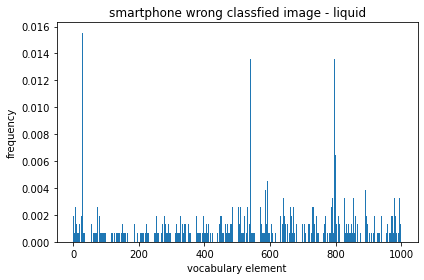

In [38]:
# [5, 'SmartPhone', 'Liquid']
smartphone_x_img_liquid = cv2.imread(sp_valid[5], cv2.IMREAD_GRAYSCALE)
kps = detector.detect(smartphone_x_img_liquid, None)
descr = bowExtractor.compute(smartphone_x_img_liquid, kps)

plt.figure()
plt.title("smartphone wrong classfied image - liquid")
plt.bar(np.arange(len(descr[0])), descr[0])
plt.xlabel('vocabulary element')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()